In [153]:
# 20240626 To classify segmented images in DNDF 101
# 20240711 To classify segmented images in BCI

In [154]:
import os
import pandas as pd
import numpy as np
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Define a custom dataset class
class CustomDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

## Step 1: Data Preparation

In [155]:
data_dir = 'h:\\Yehmh\\DNDF\\101_1_focus\\202404_101_seg_images_labeled_part_2'
# data_dir = 'h:\\Yehmh\\BCI\\2020_08_01_seg_images_labeled'

X = []  # Features
y = []  # Labels

for folder in os.listdir(data_dir):
    for file in os.listdir(os.path.join(data_dir, folder)):
        if file.endswith(".tif"):
            image_path = os.path.join(data_dir, folder, file)
            image = cv2.imread(image_path)
            if image.shape[0] >= 64:
                image = cv2.resize(image, (64, 64))  # Resize image if necessary
            else:
                print("image size: ", image.shape)
                continue
            
            X.append(image)
            y.append(folder)

image size:  (61, 71, 3)


In [156]:
# import matplotlib.pyplot as plt

# for image in X:
#     plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
#     plt.axis('off')
#     plt.show()

## Step 2: Data Preprocessing

In [157]:
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [158]:
print(label_encoder.classes_)
print(y)
print(len(X_train), len(X_test))

['Bisc_ja' 'Frax_gr' 'Liqu_fo']
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0]
28 7


## Step 3: Define transformations and create datasets

In [159]:
# transform = transforms.Compose([
#     transforms.ToTensor(),  # Convert image to PyTorch tensor
#     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize image data
# ])

# train_dataset = CustomDataset(X_train, y_train, transform=transform)
# test_dataset = CustomDataset(X_test, y_test, transform=transform)

In [160]:
# Data Augmentation ------

from PIL import Image

train_transform = transforms.Compose([
    transforms.Lambda(lambda x: Image.fromarray(x)),  # Convert NumPy array to PIL Image
    transforms.RandomHorizontalFlip(),  # Randomly flip the images horizontally
    transforms.RandomRotation(degrees=15),  # Randomly rotate the images by up to 15 degrees
    transforms.RandomCrop(size=(64, 64), padding=4),  # Randomly crop a 32x32 region of the image with padding
    transforms.ToTensor(),  # Convert image to PyTorch tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize image data
])

test_transform = transforms.Compose([
    transforms.ToTensor(),  # Convert image to PyTorch tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize image data
])

train_dataset = CustomDataset(X_train, y_train, transform=train_transform)
test_dataset = CustomDataset(X_test, y_test, transform=test_transform)

print(len(train_dataset), len(test_dataset))

28 7


## Step 4: Create data loaders

In [161]:
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
# test_loader is created with shuffle=False. 
# Ensures that the evaluation process remains consistent across different evaluations 
# and that the model is tested on the same data distribution every time

## Step 5: Define the CNN model

In [162]:
print(image.shape)

(64, 64, 3)


In [163]:
class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        # Define the convolutional layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)     # (in_channels (rgb), out_channels, filter_num, stride, padding), default stride = 1
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        # Define the fully connected layers
        self.fc1 = nn.Linear(64 * 8 * 8, 128)
        # self.fc1 = nn.Linear(64 * 4 * 4, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        # Define the forward pass through the network
        x = nn.functional.relu(self.conv1(x))
        x = nn.functional.max_pool2d(x, 2)
        x = nn.functional.relu(self.conv2(x))
        x = nn.functional.max_pool2d(x, 2)
        x = nn.functional.relu(self.conv3(x))
        x = nn.functional.max_pool2d(x, 2)
        # x = x.view(-1, 64 * 16 * 16)
        x = x.view(x.size(0), -1)
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x
        # return nn.functional.softmax(x, dim=1)  # Apply softmax activation for multi-class classification

## Step 6: Initialize model. loss function, and optimizer

In [164]:
model = CNN(num_classes=len(label_encoder.classes_))
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [165]:
print(len(label_encoder.classes_))

3


## Step 7: Train the model

In [166]:
def accuracy(predictions, labels):
    pred = torch.max(predictions.data, 1)[1]
    rights = pred.eq(labels.data.view_as(pred)).sum()
    return rights, len(labels)

In [167]:
# num_epochs = 5000
# for epoch in range(num_epochs):
#     model.train()
#     for images, labels in train_loader:
#         # print("Batch Shape - Images:", images.shape)
#         # print("Batch Shape - Labels:", labels.shape)

#         optimizer.zero_grad()   # Zero the gradient
#         outputs = model(images) # Forward pass: computer predicted outputs
#         # print(outputs.shape)
#         loss = criterion(outputs, labels) # Compute the loss
#         loss.backward()     # Backward pass: compute gradient of the loss with respect to model parameters
#         optimizer.step()    # Update the model parameters based on the gradients

#     print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item()}")

Epoch [1/100], Loss: 1.1198257207870483, Accuracy: 0.21428571428571427
Epoch [2/100], Loss: 1.0163518190383911, Accuracy: 0.5357142857142857
Epoch [3/100], Loss: 1.1110498905181885, Accuracy: 0.5357142857142857
Epoch [4/100], Loss: 0.9755342602729797, Accuracy: 0.5357142857142857
Epoch [5/100], Loss: 0.991939127445221, Accuracy: 0.75
Epoch [6/100], Loss: 0.9716282486915588, Accuracy: 0.75
Epoch [7/100], Loss: 0.9198223352432251, Accuracy: 0.6428571428571429
Epoch [8/100], Loss: 0.8576350212097168, Accuracy: 0.6071428571428571
Epoch [9/100], Loss: 0.7985243201255798, Accuracy: 0.5714285714285714
Epoch [10/100], Loss: 0.7184049487113953, Accuracy: 0.7142857142857143
Epoch [11/100], Loss: 0.6495059728622437, Accuracy: 0.75
Epoch [12/100], Loss: 0.5754889845848083, Accuracy: 0.7857142857142857
Epoch [13/100], Loss: 0.5028618574142456, Accuracy: 0.75
Epoch [14/100], Loss: 0.47691914439201355, Accuracy: 0.7142857142857143
Epoch [15/100], Loss: 0.414913147687912, Accuracy: 0.7857142857142857


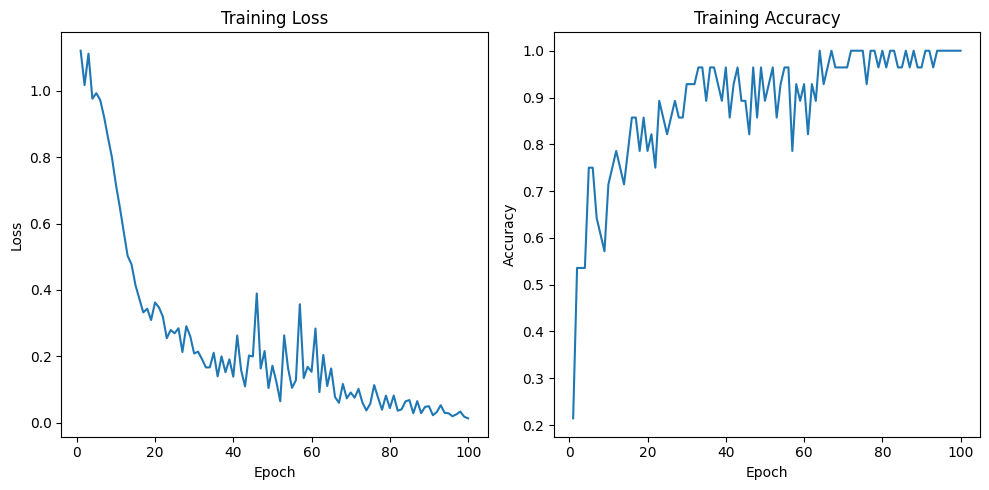

In [168]:
import matplotlib.pyplot as plt

num_epochs = 100
train_losses = []
train_accuracies = []

for epoch in range(num_epochs):
    model.train()
    correct = 0
    total = 0
    epoch_loss = 0.0
    
    for images, labels in train_loader:
        optimizer.zero_grad()   # Zero the gradient
        outputs = model(images) # Forward pass: compute predicted outputs
        loss = criterion(outputs, labels) # Compute the loss
        loss.backward()     # Backward pass: compute gradient of the loss with respect to model parameters
        optimizer.step()    # Update the model parameters based on the gradients
        
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        epoch_loss += loss.item()

    train_accuracy = correct / total
    train_loss = epoch_loss / len(train_loader)
    train_accuracies.append(train_accuracy)
    train_losses.append(train_loss)

    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {train_loss}, Accuracy: {train_accuracy}")

# Plotting
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')

plt.tight_layout()
plt.show()


## Step 8: Evaluate the model

In [169]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Print the predicted and actual labels
        for i in range(len(labels)):
            print("Predicted: {}, Actual: {}".format(predicted[i], labels[i]))

accuracy = correct / total
print('Test Accuracy: {:.2f}%'.format(100 * accuracy))

Predicted: 2, Actual: 2
Predicted: 1, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 1, Actual: 1
Predicted: 0, Actual: 0
Predicted: 2, Actual: 2
Test Accuracy: 100.00%


Predicted: 2, Actual: 2
Predicted: 1, Actual: 1
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 1, Actual: 1
Predicted: 0, Actual: 0
Predicted: 2, Actual: 2
Test Accuracy: 100.00%


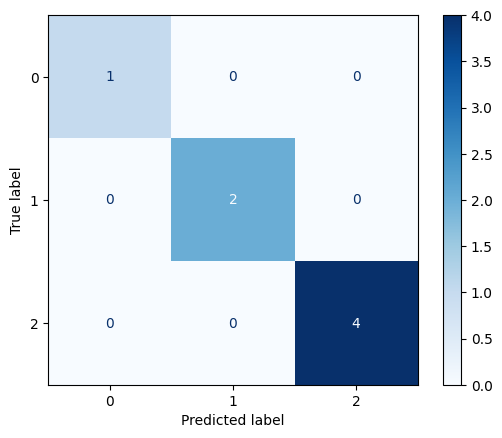

In [170]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Assuming test_loader, model are already defined

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        # Print the predicted and actual labels
        for i in range(len(labels)):
            print("Predicted: {}, Actual: {}".format(predicted[i], labels[i]))

# Calculate accuracy
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)
accuracy = (all_preds == all_labels).sum() / len(all_labels)
print('Test Accuracy: {:.2f}%'.format(100 * accuracy))

# Generate and plot confusion matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)

plt.show()

In [179]:
# Save the model
torch.save(model.state_dict(),  f'h:\Yehmh\_model\\0807_DNDF_101_CNN_{int(100 * accuracy)}.pth')

Predicted: Liqu_fo, Actual: Liqu_fo
Predicted: Frax_gr, Actual: Frax_gr
Predicted: Liqu_fo, Actual: Liqu_fo
Predicted: Liqu_fo, Actual: Liqu_fo
Predicted: Frax_gr, Actual: Frax_gr
Predicted: Bisc_ja, Actual: Bisc_ja
Predicted: Liqu_fo, Actual: Liqu_fo
Test Accuracy: 100.00%


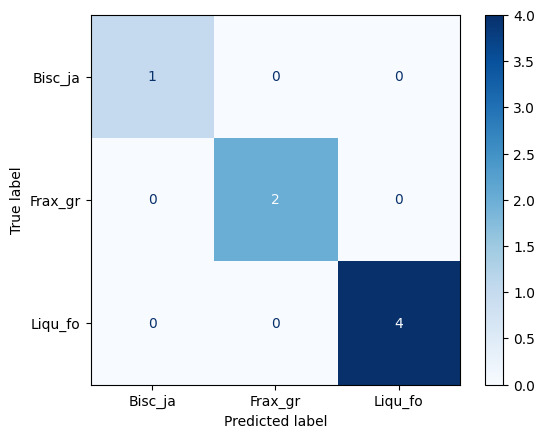

In [182]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Assuming test_loader, model are already defined

class_names = ['Bisc_ja', 'Frax_gr', 'Liqu_fo']  # Define your class names here


# Load the trained model
model = CNN(num_classes=len(label_encoder.classes_))
model.load_state_dict(torch.load('h:\Yehmh\_model\\0807_DNDF_101_CNN_100.pth'))

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        # Print the predicted and actual labels
        for i in range(len(labels)):
            print("Predicted: {}, Actual: {}".format(class_names[predicted[i]], class_names[labels[i]]))

# Calculate accuracy
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)
accuracy = (all_preds == all_labels).sum() / len(all_labels)
print('Test Accuracy: {:.2f}%'.format(100 * accuracy))

# Generate and plot confusion matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)

plt.show()


## Classify Whole

In [173]:
# import os
# import cv2
# import torch
# import rasterio
# import numpy as np
# from torch.utils.data import DataLoader
# from torchvision import transforms
# # from your_model_file import CNN  # Import your CNN model class
# import csv

# # Function to extract coordinates from TIF files
# def extract_coordinates(tif_file):
#     with rasterio.open(tif_file) as src:
#         crs = src.crs
#         bounds = src.bounds
#         center_x = (bounds.left + bounds.right) / 2
#         center_y = (bounds.top + bounds.bottom) / 2
#         return crs, (center_x, center_y)

# # Define directory containing unknown TIF files
# # unknown_photos_dir = 'D:\\Yehmh\\test_py\\202301\\P00073_transect_234\\10m_10m\\unknown'

# def classify_and_write(unknown_photos_dir, output_csv_path):

#     # Initialize lists to store unknown photo paths, coordinates, and predictions
#     unknown_photos = []
#     unknown_coordinates = []

#     # Iterate over unknown TIF files
#     for filename in os.listdir(unknown_photos_dir):
#         if filename.endswith('.tif'):
#             tif_file = os.path.join(unknown_photos_dir, filename)
            
#             # Extract coordinates
#             crs, coordinates = extract_coordinates(tif_file)
            
#             # Append to the list
#             unknown_photos.append(tif_file)
#             unknown_coordinates.append((filename, crs, coordinates))

#     # Now you have a list of unknown photo paths (unknown_photos) and corresponding coordinates (unknown_coordinates)

#     # Load the trained model
#     # model = CNN(num_classes=len(label_encoder.classes_))
#     # model.load_state_dict(torch.load('path/to/your/trained/model.pth'))
#     model.eval()  # Set the model to evaluation mode

#     # Define transformations for the images
#     transform = transforms.Compose([
#         transforms.ToTensor(),  
#         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  
#     ])

#     # Make predictions on the unknown photos
#     predictions = []
#     for photo_path in unknown_photos:
#         # Load and preprocess the image
#         image = cv2.imread(photo_path)
#         image = cv2.resize(image, (64, 64))  # Resize image if necessary
#         image = transform(image)
#         image = image.unsqueeze(0)  # Add batch dimension
        
#         # Perform inference
#         with torch.no_grad():
#             output = model(image)
#             predicted_class = torch.argmax(output).item()
#             predicted_label = label_encoder.classes_[predicted_class]
#             predictions.append(predicted_label)

#     # Now you have the predictions for each unknown photo in the list 'predictions'
#     # You can proceed to visualize the results on a map using the coordinates
#     with open(output_csv_path, 'w', newline='') as csvfile:
#         writer = csv.writer(csvfile)
#         writer.writerow(['Filename', 'Latitude', 'Longitude', 'Predicted Species'])  # Write header
#         for coord, label in zip(unknown_coordinates, predictions):
#             filename, crs, (latitude, longitude) = coord
#             writer.writerow([filename, latitude, longitude, label])

In [174]:
# import csv

# # Define output CSV file path
# # output_csv_path = 'D:/Yehmh/test_py/202301/P00073_transect_234/10m_10m/species_distribution.csv'


# # Write results to CSV file
# with open(output_csv_path, 'w', newline='') as csvfile:
#     writer = csv.writer(csvfile)
#     writer.writerow(['Filename', 'Latitude', 'Longitude', 'Predicted Species'])  # Write header
#     for coord, label in zip(unknown_coordinates, predictions):
#         filename, crs, (latitude, longitude) = coord
#         writer.writerow([filename, latitude, longitude, label])


In [175]:
# list = [69, 70, 71, 75, 76, 78, 79, 82]

# for i in list:
#     unknown_photos_dir = f'D:\\Yehmh\\test_py\\202301\\P000{i}\\5m_5m'
#     output_csv_path = f'D:/Yehmh/test_py/202301/P000{i}_species_distribution.csv'
    
#     classify_and_write(unknown_photos_dir, output_csv_path)
    
#     print(i, " done")

### add probabilities

In [176]:
# import os
# import cv2
# import torch
# import rasterio
# import numpy as np
# from torch.utils.data import DataLoader
# from torchvision import transforms
# # from your_model_file import CNN  # Import your CNN model class
# import csv

# # Function to extract coordinates from TIF files
# def extract_coordinates(tif_file):
#     with rasterio.open(tif_file) as src:
#         crs = src.crs
#         bounds = src.bounds
#         center_x = (bounds.left + bounds.right) / 2
#         center_y = (bounds.top + bounds.bottom) / 2
#         return crs, (center_x, center_y)

# # Define directory containing unknown TIF files
# # unknown_photos_dir = 'D:\\Yehmh\\test_py\\202301\\P00073_transect_234\\10m_10m\\unknown_cleaned'

# def classify_and_write(unknown_photos_dir, output_csv_path):

#     # Initialize lists to store unknown photo paths, coordinates, and predictions
#     unknown_photos = []
#     unknown_coordinates = []

#     # Iterate over unknown TIF files
#     for filename in os.listdir(unknown_photos_dir):
#         if filename.endswith('.tif'):
#             tif_file = os.path.join(unknown_photos_dir, filename)
            
#             # Extract coordinates
#             crs, coordinates = extract_coordinates(tif_file)
            
#             # Append to the list
#             unknown_photos.append(tif_file)
#             unknown_coordinates.append((filename, crs, coordinates))

#     # Now you have a list of unknown photo paths (unknown_photos) and corresponding coordinates (unknown_coordinates)

#     # Define a function to classify with threshold
#     def classify_with_threshold(probabilities, threshold):
#         max_prob, max_index = torch.max(probabilities, dim=1)
#         if max_prob.item() < threshold:
#             return "unknown"
#         else:
#             predicted_label = label_encoder.classes_[max_index.item()]
#             return predicted_label  # Return the index of the class with the maximum probability


#     # Load the trained model
#     # model = CNN(num_classes=len(label_encoder.classes_))
#     # model.load_state_dict(torch.load('path/to/your/trained/model.pth'))
#     model.eval()  # Set the model to evaluation mode

#     # Define transformations for the images
#     transform = transforms.Compose([
#         transforms.ToTensor(),  
#         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  
#     ])

#     # Make predictions on the unknown photos
#     predictions = []
#     for photo_path in unknown_photos:
#         # Load and preprocess the image
#         image = cv2.imread(photo_path)
#         image = cv2.resize(image, (64, 64))  # Resize image if necessary
#         image = transform(image)
#         image = image.unsqueeze(0)  # Add batch dimension
        
#         # Perform inference
#         with torch.no_grad():
#             output = model(image)
#             probabilities = nn.functional.softmax(output, dim=1)  # Apply softmax to get probabilities
#             classification = classify_with_threshold(probabilities, threshold=0.7)  # Adjust threshold as needed
#             predictions.append(classification)

#     # Now you have the predictions for each unknown photo in the list 'predictions'
#     # You can proceed to visualize the results on a map using the coordinates
#     with open(output_csv_path, 'w', newline='') as csvfile:
#         writer = csv.writer(csvfile)
#         writer.writerow(['Filename', 'Latitude', 'Longitude', 'Predicted Species'])  # Write header
#         for coord, label in zip(unknown_coordinates, predictions):
#             filename, crs, (latitude, longitude) = coord
#             writer.writerow([filename, latitude, longitude, label])

In [177]:
# import csv

# # Define output CSV file path
# output_csv_path = 'D:/Yehmh/test_py/202301/P00073_transect_234/10m_10m/species_distribution_unclassified_2.csv'

# # Write results to CSV file
# with open(output_csv_path, 'w', newline='') as csvfile:
#     writer = csv.writer(csvfile)
#     writer.writerow(['Filename', 'Latitude', 'Longitude', 'Predicted Species'])  # Write header
#     for coord, label in zip(unknown_coordinates, predictions):
#         filename, crs, (latitude, longitude) = coord
#         writer.writerow([filename, latitude, longitude, label])

In [178]:
# unknown_photos_dir = 'h:\\Yehmh\\DNDF\\101_1_focus\\202404_101_seg_images'
# output_csv_path = 'h:\\Yehmh\\DNDF\\101_1_focus\\20240626_CNN_prob.csv'
# classify_and_write(unknown_photos_dir, output_csv_path)
# print("done 1")